## Case Study: The Energy Costs of Echolocation by Bats—An Observational Study

Zoologists measured the energy cost of echolocation and flight in bats, flight energy cost of non-echolocating bats and birds and their body weights. They wondered whether the combined energy costs of echolocation and flight in bats was the sum of the flight energy costs and the at-rest echolocation energy costs.


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
import statsmodels.formula.api as smf
sns.set_style('whitegrid')

In [141]:
path = 'sleuth3csv/case1002.csv'
df = pd.read_csv(path)
df.head()

,Mass,Type,Energy
0,779.0,non-echolocating bats,43.70
1,628.0,non-echolocating bats,34.80
2,258.0,non-echolocating bats,23.30
3,315.0,non-echolocating bats,22.40
4,24.3,non-echolocating birds,2.46


In [38]:
df.describe(include='all')

,Mass,Type,Energy
count,20.000000,20,20.000000
unique,NaN,3,NaN
top,NaN,non-echolocating birds,NaN
freq,NaN,12,NaN
mean,262.675000,NaN,19.518000
std,220.900239,NaN,13.998325
min,6.700000,NaN,1.020000
25%,63.350000,NaN,7.605000
50%,266.500000,NaN,22.600000
75%,391.000000,NaN,28.225000


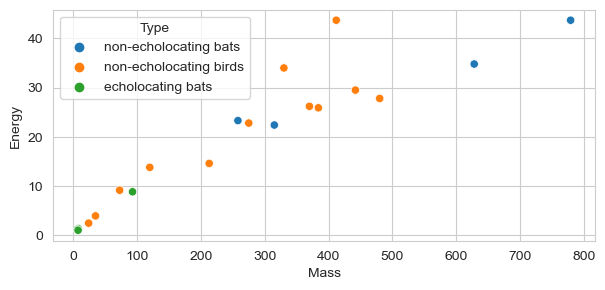

In [77]:
f, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x='Mass', y='Energy', hue = "Type", data = df, ax=ax)
plt.show()

Some data points are clustered on top of each other and the spread is increasing with Mass. Let's consider log transformations.

In [142]:
df['logEnergy'] = np.log(df['Energy'])
df['logMass'] = np.log(df['Mass'])
df.head()

,Mass,Type,Energy,logEnergy,logMass
0,779.0,non-echolocating bats,43.70,3.777348,6.658011
1,628.0,non-echolocating bats,34.80,3.549617,6.442540
2,258.0,non-echolocating bats,23.30,3.148453,5.552960
3,315.0,non-echolocating bats,22.40,3.109061,5.752573
4,24.3,non-echolocating birds,2.46,0.900161,3.190476


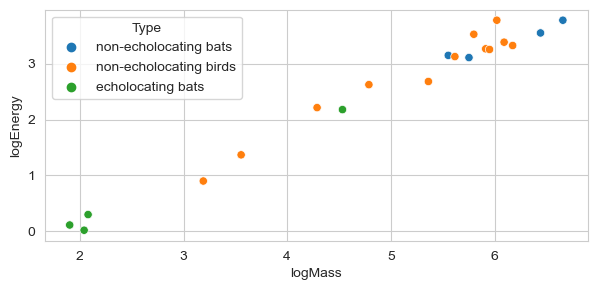

In [79]:
f, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x='logMass', y='logEnergy', hue = "Type", data = df, ax=ax)
plt.show()

This scatter plot shows a clear linear association between logMass and logEnergy. Also, it seems that most of echolocating bats have small masses compared to non-echolocating bats. This can be a strong predictor of energy so need to include this variable in the analysis with caution. 

In [143]:
df["Type_orig"] = df["Type"]
df = pd.get_dummies(df, columns=['Type'])
d = {'Type_echolocating bats': 'ebat', 'Type_non-echolocating bats': 'nebat', 'Type_non-echolocating birds': 'bird', 'Type_orig':'Type'}
df = df.rename(columns = d)
df.head()

,Mass,Energy,logEnergy,logMass,Type,ebat,nebat,bird
0,779.0,43.70,3.777348,6.658011,non-echolocating bats,0,1,0
1,628.0,34.80,3.549617,6.442540,non-echolocating bats,0,1,0
2,258.0,23.30,3.148453,5.552960,non-echolocating bats,0,1,0
3,315.0,22.40,3.109061,5.752573,non-echolocating bats,0,1,0
4,24.3,2.46,0.900161,3.190476,non-echolocating birds,0,0,1


The third level of TYPE, non-echolocating bats, will be treated as the reference level, so its indicator variable will not appear in the regression model. We need to check association between energy with TYPE after accounting for the body mass so we consider the model:

$$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass + \beta_2 bird + \beta_3 ebat$$

This model suggests three straight lines with equal slope of $\beta_1$ as follows.

$$\mu\{lenergy|lmass,nebat\} = \beta_0+\beta_1 lmass$$

with slope of $\beta_1$ and intercept of $\beta_0$,

$$\mu\{lenergy|lmass,bird\} = \beta_0+\beta_1 lmass + \beta_2$$

with slope of $\beta_1$ and intercept of $\beta_0+\beta_2$,

$$\mu\{lenergy|lmass,ebat\} = \beta_0+\beta_1 lmass + \beta_3$$

with slope of $\beta_1$ and intercept of $\beta_0 + \beta_3$.


In [81]:
model = smf.ols("logEnergy ~ logMass + bird + ebat", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     283.6
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           4.46e-14
Time:                        13:38:16   Log-Likelihood:                 7.4968
No. Observations:                  20   AIC:                            -6.994
Df Residuals:                      16   BIC:                            -3.011
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5764      0.287     -5.488      0.0

In [55]:
results.params

Intercept   -1.576360
logMass      0.814957
bird         0.102262
ebat         0.078664
dtype: float64

In [82]:
necho_pred = results.params.Intercept + results.params.logMass*df['logMass']
bird_pred = results.params.Intercept + results.params.logMass*df['logMass'] + results.params.bird
ebat_pred = results.params.Intercept + results.params.logMass*df['logMass'] + results.params.ebat

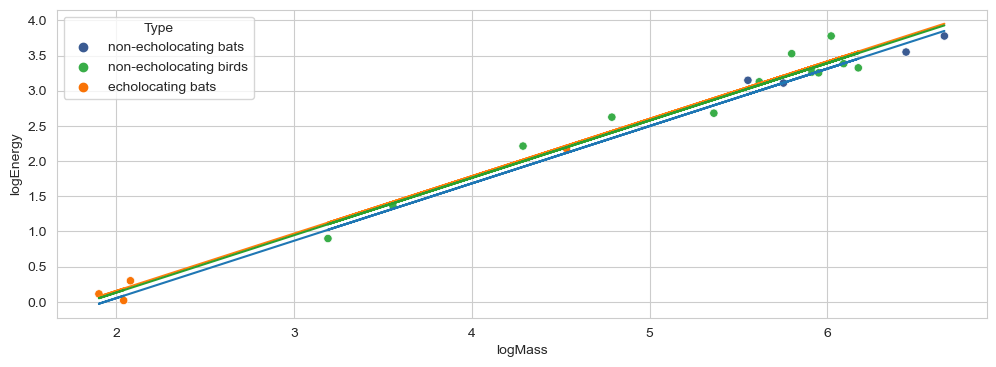

In [83]:
colors = ["denim blue", "medium green", "orange"]
palette = sns.xkcd_palette(colors)

fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(x='logMass', y='logEnergy', hue = "Type", data = df, ax=ax, palette=palette)
ax.plot(df['logMass'], necho_pred)
ax.plot(df['logMass'], bird_pred)
ax.plot(df['logMass'], ebat_pred)
plt.show()

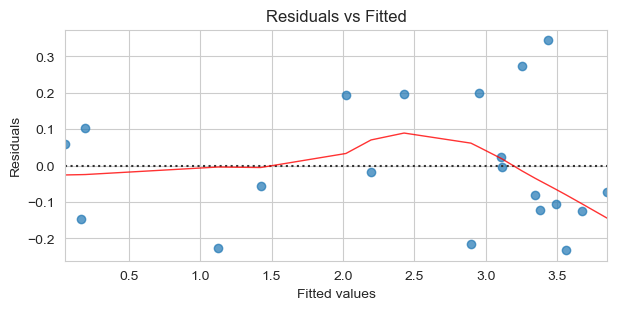

In [87]:
plt.figure(figsize=(7,3))

# fitted values (predicted values)
model_fitted_y = results.fittedvalues

#  Plot
plot = sns.residplot(x=model_fitted_y, y='logEnergy', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.7}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals');

In [86]:
shapiro(results.resid)

ShapiroResult(statistic=0.9433696866035461, pvalue=0.27742016315460205)

Since the p-value from the Shapiro is large we do not reject the hypothesis that residual is white noise.

If the distribution of the response for each combination of the explanatory variables is normal with constant variance, then

## the t-ratios of coefficients

$$t\_ratio = \frac{\hat{\beta}_j-\beta_j}{SE(\hat{\beta}_j)}$$

Formula for the $SE(\hat{\beta}_j)$ is omitted here since it requires matrix computations. However, the computer test result output contains standard error values.

### Do Non-Echolocating Bats Differ from Echolocating Bats of similar size? Test for $ \beta_3 = 0$

The mean log energy expenditure for echolocating bats is $\beta_3$ units more than the mean log energy for non-echolocating bats.

The two sided p-value for the test $\beta_3=0$ is provided in the computer output as 0.703, providing no reason to doubt that $\beta_3=0$ (degree of freedom = 16, t-statistic = 0.388, 95% confidence interval = (-0.351, 0.508)).

However, this does **not** mean that the test has proved that $\beta_3=0$.

Echolocating bats might have a higher energy expenditure, but the available study may not be powerful enough to detect this difference. 






If the parallel regression lines model is correct:

\begin{equation}
\begin{split}
\mu\{lenergy|lmass,ebat\} - \mu\{lenergy|lmass,nebat\} & = \beta_0+\beta_1 lmass + \beta_3 - (\beta_0+\beta_1 lmass) = \beta_3\\
difference\_\mu\{lenergy\} & = \beta_3\\
difference\_Median\{lenergy\} & = \beta_3\\
difference\_\log\{Median\_energy\} & = \beta_3\\
difference\{Median\_energy\} & = \exp{(\beta_3)}
\end{split}
\end{equation}




If the parallel regression lines model is correct, the median in-flight energy expenditure is $\exp(\beta_3)$ times as great for echolocating bats as it is for non-echolocating bats of similar body mass.

That is the median in-flight energy expenditure for echolocating bats is estimated to be $e^{0.0787} = 1.08$ times as large as that for non-echolocating bats, after accounting for body mass. 95% confidence interval is $(e^{-0.351}, e^{0.508}) = (0.7, 1.66)$.


We considered the model 
$$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass + \beta_2 bird + \beta_3 ebat \;\;\;\;\;\;\;\; (1)$$

Now let's consider the model

$$\mu\{lenergy|lmass,TYPE\} = \alpha_0+\alpha_1 ebat + \alpha_2 bird \;\;\;\;\;\;\;\; (2)$$

In model (1), the coefficient of ebat measures the difference between energy
expenditure of echolocating bats and of non-echolocating bats after adjusting for body size. 

In model (2), the coefficient of ebat measures the difference between mean log energy among echolocating bats and mean log energy among non-echolocating bats, ignoring any explanation of differences based on body size. 

In [88]:
model = smf.ols("logEnergy ~ ebat + bird", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     12.50
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           0.000458
Time:                        20:09:56   Log-Likelihood:                -23.379
No. Observations:                  20   AIC:                             52.76
Df Residuals:                      17   BIC:                             55.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3961      0.422      8.041      0.0

Since all the echolocating bats were small and all the non- echolocating bats were large. 
The echolocating versus non-echolocating difference is thus confounded with the differences based on body size.

"After adjusting for body size” means that group differences are considered only after the best explanation for body size is taken into account.

Since body size explains the differences well, the coefficient of ebat in model (1) is insignificant event though in model (2) it is significant.

$$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass + \beta_2 bird + \beta_3 ebat \;\;\;\;\;\;\;\; (1)$$
According to the model (1)

$$\text{Test on equality of energy distribution in birds and non-echolocating bats} = \text{test whether } \beta_2 \text{ is zero}$$

$$\text{Test on equality of energy distribution in echolocating bats and non-echolocating bats} = \text{test whether } \beta_3 \text{ is zero}$$

These two test results are included in the model results page. However

$$\text{Test on equality of energy distribution in birds and echolocating bats} = \text{test whether } \beta_2-\beta_3 \text{ is zero}$$

is **not** included.

A simple computer trick to solve this issue is to change the reference level to birds or echolocating bats as shown below.

In [89]:
model = smf.ols("logEnergy ~ logMass + bird + nebat", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     283.6
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           4.46e-14
Time:                        20:37:59   Log-Likelihood:                 7.4968
No. Observations:                  20   AIC:                            -6.994
Df Residuals:                      16   BIC:                            -3.011
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4977      0.150     -9.993      0.0

From the test output the estimation of $\beta_2-\beta_3$ is 0.0236 (after accounting for body mass). 

The hypothesis $\beta_2-\beta_3=0$ is not rejected. Two sided p-value = 0.883 (t-test with df = 16). 

## How to test on any linear combinations of regression coefficients

Variance Formulas for Linear Combinations of Regression Coefficients

In general, a linear combination can be written as

$$\gamma = C_0\beta_0+C_1\beta_1+....+C_p\beta_p$$

where the C’s are known coefficients.


The estimate of this combination is

$$g = C_0\hat{\beta}_0+C_1\hat{\beta}_1+....+C_p\hat{\beta}_p $$

We need to know the standard error of $g$.

$$Var(g) = C_0^2 SE(\hat{\beta}_0)^2+C_1^2 SE(\hat{\beta}_1)+...+C_p SE(\hat{\beta}_p)+2 C_0C_1 Cov(\hat{\beta}_0,\hat{\beta}_1)+2C_0C_2 Cov(\hat{\beta}_0,\hat{\beta}_2)+....+2C_{p-1}C_p Cov(\hat{\beta}_{p-1},\hat{\beta}_p)$$

$SE(g) = \sqrt{Var{(g)}}$

Test:

\begin{equation}
\begin{split}
& H_0: \gamma = \gamma_0\\
& H_1: \gamma\neq \gamma_0
\end{split}
\end{equation}

$$ \text{T} = \frac{g-\gamma_0}{SE(g)}\sim t_{(n-\text{Num. of para. in the model)}}$$


Example: Let's confirm the previous test on $\beta_2-\beta_3$ with this method. 

The model is $$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass + \beta_2 bird + \beta_3 ebat \;\;\;\;\;\;\;\; (1)$$

In [144]:
model = smf.ols("logEnergy ~ logMass + bird + ebat", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     283.6
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           4.46e-14
Time:                        16:17:38   Log-Likelihood:                 7.4968
No. Observations:                  20   AIC:                            -6.994
Df Residuals:                      16   BIC:                            -3.011
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5764      0.287     -5.488      0.0

In [153]:
#for covariance matrix of parameters
covmat = results.cov_params()
print(covmat)

           Intercept   logMass      bird      ebat
Intercept   0.082505 -0.012105 -0.019207 -0.050561
logMass    -0.012105  0.001984  0.001731  0.006870
bird       -0.019207  0.001731  0.013038  0.014639
ebat       -0.050561  0.006870  0.014639  0.041079


Test on equality of energy distribution in birds and echolocating bats

$\gamma = \beta_2-\beta_3$ 

Test:

\begin{equation}
\begin{split}
& H_0: \gamma = 0\\
& H_1: \gamma\neq 0
\end{split}
\end{equation}

$g = \hat{\beta}_2-\hat{\beta}_3 = 0.1023-0.0787 = 0.0236$

$Var(g) = SE(\hat{\beta}_2)^2+SE(\hat{\beta}_3)^+2(1)(-1)Cov(\hat{\beta}_2, \hat{\beta}_3) = 0.013038 + 0.041079 - 2*0.014639 = 0.024839$

$SE(g) = 0.024839^{1/2} = 0.1576$

$t_stat = \frac{0.0236}{0.1576} = 0.1497$

In [154]:
## to calculate p-value

scipy.stats.t.sf(abs(0.1497), df=16)*2

0.8828720924869151

We confirm our calculation and no evidence that the energy distribution in birds and echolocating bats is different  after acccounting for body size.

## Extra sum of squares F-tests

In multiple regression, data analysts often need to test whether several coefficients
are all zero. 

Example:
$$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass + \beta_2 bird + \beta_3 ebat \;\;\;\;\;\;\;\; \text{Full model}$$

$$H_0: \beta_2=0=\beta_3$$
$$H_1: \beta_2\neq 0 \text{ or } \beta_3\neq 0$$

We consider a reduced model to conduct this test:

$$\mu\{lenergy|lmass,TYPE\} = \beta_0+\beta_1 lmass \;\;\;\;\;\;\;\; \text{Reduced model}$$

\begin{equation}
\begin{split}
\text{Extra sum of Squares } = \text{ Sum of squred residuals from reduced model} - \text{ Sum of squred residuals from full model}
\end{split}
\end{equation}

Note that since the full model has more variables than the reduced model, squared sum of residuals from the full model is lower than it is from the reduced model.

Extra sum of squares is the amount variance in response variable explained by the two extra (in this example) variable, ebat and bird. 

$$\text{F-statistic} = \frac{\frac{\text{Extra sum of squares}}{\text{Number of coefficients being tested}}}{\frac{ \text{Sum of square residuals from Full model}}{\text{(Num. of observations - Num. parameters in Full model)}}}$$

If the reduced model is correct, then per-coefficient variation should be roughly equal to the per observation variation. The F-statistic, therefore, should be close to 1.

Although exact justification is based on normality, the F -test and the t-tests are robust against departures from normality.

If the F-statistic is larger than $F_{\text{Numerator d.f }, \text{Denominator d.f. }}$, we have evidence that the reduced model is incorrect where,

Numerator d.f = Number of coefficients being tested

Denominator d.f. = Num. of observations - Num. parameters in Full model

In [123]:
model = smf.ols("logEnergy ~ logMass + bird + ebat", data = df)
results_full = model.fit()
print(results_full.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     283.6
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           4.46e-14
Time:                        14:38:08   Log-Likelihood:                 7.4968
No. Observations:                  20   AIC:                            -6.994
Df Residuals:                      16   BIC:                            -3.011
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5764      0.287     -5.488      0.0

In [124]:
model = smf.ols("logEnergy ~ logMass", data = df)
results_reduced = model.fit()
print(results_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:              logEnergy   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     907.6
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           7.44e-17
Time:                        14:38:29   Log-Likelihood:                 6.9761
No. Observations:                  20   AIC:                            -9.952
Df Residuals:                      18   BIC:                            -7.961
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4683      0.137    -10.705      0.0

In [131]:
sum_of_sqrd_resid_full = (results_full.resid**2).sum()
sum_of_sqrd_resid_reduced = (results_reduced.resid**2).sum()
extra_sum_squares = sum_of_sqrd_resid_reduced - sum_of_sqrd_resid_full

print("sum_of_sqrd_resid_full = ", sum_of_sqrd_resid_full)
print("sum_of_sqrd_resid_reduced = ", sum_of_sqrd_resid_reduced)

coeff_tested = 2
df_full = 20 - 4

f_stat = (extra_sum_squares/coeff_tested)/(sum_of_sqrd_resid_full/df_full)

print("f_statistic = ", f_stat)

from scipy.stats import f
pValue = 1 - f.cdf(f_stat,coeff_tested,df_full)
print("p-value = ", pValue)

sum_of_sqrd_resid_full =  0.5533175347246567
sum_of_sqrd_resid_reduced =  0.5828911268810112
f_statistic =  0.4275822152799976
p-value =  0.6593194871591793


There is no evidence that mean log energy differs for birds, echolocating bats, and non-echolocating bats, after accounting for body mass.

anova_lm function can be used to conduct this test directly.

In [127]:
from statsmodels.stats.anova import anova_lm

In [136]:
# Perform analysis of variance on fitted linear model (reduced model is in the first argument)
anova_results = anova_lm(results_reduced, results_full)
print('\nANOVA results full model')
print(anova_results)


ANOVA results full model
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0      18.0  0.582891      0.0       NaN       NaN       NaN
1      16.0  0.553318      2.0  0.029574  0.427582  0.659319


## Case study: Galileo’s Data on the Motion of Falling Bodies—A Controlled Experiment
In 1609 Galileo proved that the trajectory of a body falling with a horizontal velocity component is a parabola.
He placed an object on an inclined table and measured the horizontal distance (units - punti) it moved from the table by varying heights.

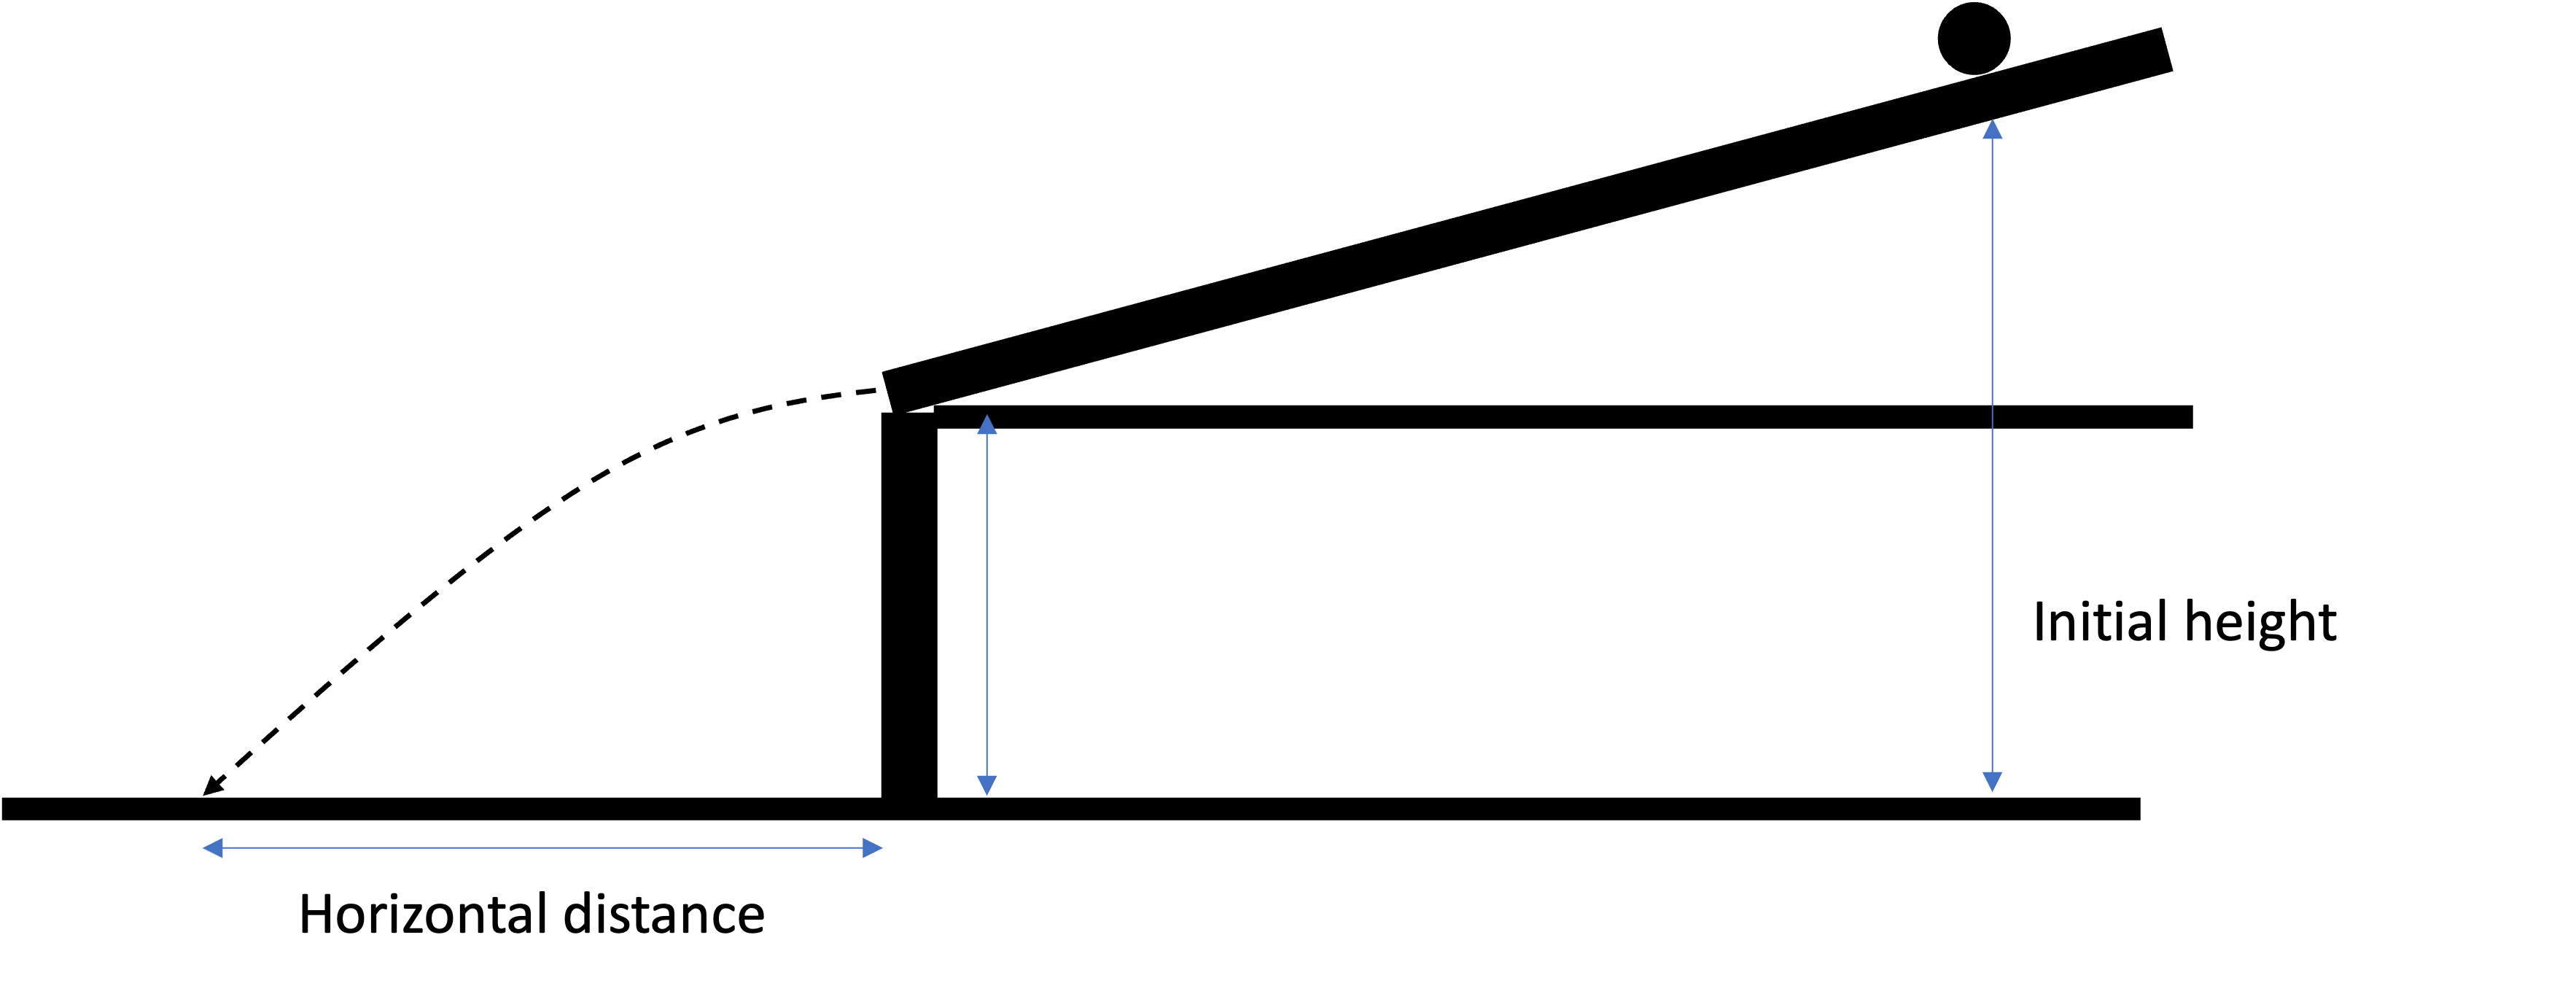


In [160]:
path = 'sleuth3csv/case1001.csv'
df = pd.read_csv(path)
df.head()

,Distance,Height
0,253,100
1,337,200
2,395,300
3,451,450
4,495,600


In [161]:
df.describe()

,Distance,Height
count,7.000000,7.000000
mean,434.000000,492.857143
std,113.300485,327.144937
min,253.000000,100.000000
25%,366.000000,250.000000
50%,451.000000,450.000000
75%,514.500000,700.000000
max,573.000000,1000.000000


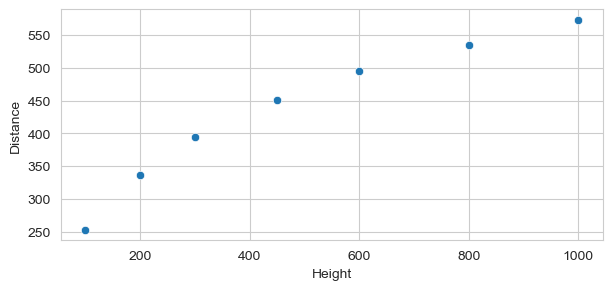

In [105]:
plt.figure(figsize=(7,3))
sns.scatterplot(y= 'Distance', x='Height', data= df)
plt.show()

Consider the model

$$\mu\{distance|height\}=\beta_0+\beta_1 height + \beta_2 height^2$$

In [156]:
model = smf.ols("Distance ~ Height + I(Height**2)", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     205.0
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           9.33e-05
Time:                        16:46:47   Log-Likelihood:                -26.264
No. Observations:                   7   AIC:                             58.53
Df Residuals:                       4   BIC:                             58.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        199.9128     16.759     11.

/Users/amilamuthunayake/miniforge3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


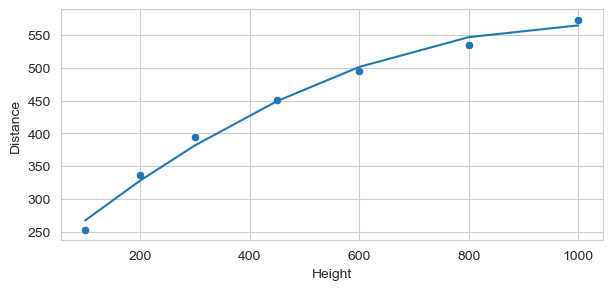

In [100]:
plt.figure(figsize=(7,3))
sns.scatterplot(y= 'Distance', x='Height', data= df)
plt.plot(df["Height"],results.fittedvalues)
plt.show()

A trick to obtain the standard error for the mean prediction when Height is 250 (say).

Include a new height column subtracting 250 from each height measurement and fit a model as before with the new height column.

The standard error of the intercept in the new model is the SE of the mean distance prediction when height is 250.

In [112]:
df["ht250"] = df["Height"]-250

model = smf.ols("Distance ~ ht250 + I(ht250**2)", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     205.0
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           9.33e-05
Time:                        21:16:09   Log-Likelihood:                -26.264
No. Observations:                   7   AIC:                             58.53
Df Residuals:                       4   BIC:                             58.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       355.5126      6.625     53.663

/Users/amilamuthunayake/miniforge3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


This also can be computed directly with get_prediction method.

In [157]:
path = 'sleuth3csv/case1001.csv'
df = pd.read_csv(path)
df.head()

,Distance,Height
0,253,100
1,337,200
2,395,300
3,451,450
4,495,600


In [187]:
model = smf.ols("Distance ~ Height + I(Height**2)", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     205.0
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           9.33e-05
Time:                        17:54:40   Log-Likelihood:                -26.264
No. Observations:                   7   AIC:                             58.53
Df Residuals:                       4   BIC:                             58.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        199.9128     16.759     11.

/Users/amilamuthunayake/miniforge3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [115]:
X_test = np.array([250])

df_new = pd.DataFrame()

df_new['Height'] = X_test

results.get_prediction(df_new).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,355.512597,6.624902,337.118921,373.906272,313.414066,397.611127


## Adjusted R^2
The adjusted $R^2$ is a version of $R^2$ that includes a penalty for unnecessary explanatory variables.

$$\text{Adjusted_} R^2 = \frac{\frac{SS_{\text{Total}}}{n-1}-\frac{SS_{\text{Residuals}}}{n-\text{num. param}}}{\frac{SS_{\text{Total}}}{n-1}}$$

Thus adjusted $R^2$ is useful for casual assessment of improvement of fit.

In [188]:
SS_mean_response = ((df["Distance"]-df["Distance"].mean())**2).sum()/6 


SS_mean_residuals = (results.resid**2).sum()/4

Adj_R2 = (SS_mean_response - SS_mean_residuals)/SS_mean_response

Adj_R2

0.9855091122195787